<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

You work for a real estate company interested in using data science to determine the best properties to buy and re-sell. Specifically, your company would like to identify the characteristics of residential houses that estimate the sale price and the cost-effectiveness of doing renovations.

There are three components to the project:

1. Estimate the sale price of properties based on their "fixed" characteristics, such as neighborhood, lot size, number of stories, etc.


2. Estimate the impact of possible renovations to properties from the variation in sale price not explained by the fixed characteristics.  

3. Bonus Question: Determine the features in the housing data that best predict "abnormal" sales (foreclosures, etc.).

#### The full description of the data features can be found in a separate file in the project-3 repo: data_description.txt

#### For question one and two you will likely need to test different models to arrive at your "best model" for each question. This should not be an exhaustive exercise as the cleaning and eda ahead is significant enough by itself.  



#### This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).



## NOTEBOOK OVERVIEW

#### > read in the dataset and get residential data only
#### > inspected all features
#### > identified low variance features and dropped 12 features
#### > replaced missing values with mean, mode, categorical label
#### > dummied categorical data and prepared data for question 1 and 2

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
import dtale
dtale.show(house)

2021-06-04 14:14:32,207 - INFO     - NumExpr defaulting to 8 threads.


In [4]:
house.shape

(1460, 81)

In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# find residential 
#        A	Agriculture
#        C	Commercial
#        FV	Floating Village Residential
#        I	Industrial
#        RH	Residential High Density
#        RL	Residential Low Density
#        RP	Residential Low Density Park 
#        RM	Residential Medium Density
        

# https://www.cityofames.org/home/showpublisheddocument/659/637455425482600000
# this reference suggests that FV is residential property

# Task: take residential subset: 'FV','RH','RL','RP','RM'

house.groupby('MSZoning').count()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSZoning,,,,,,,,,,,,,,,,,,,,,
C (all),10,10,10,10,10,2,10,10,10,10,...,10,0,3,2,10,10,10,10,10,10
FV,65,65,57,65,65,24,65,65,65,65,...,65,0,1,0,65,65,65,65,65,65
RH,16,16,13,16,16,2,16,16,16,16,...,16,0,2,0,16,16,16,16,16,16
RL,1151,1151,922,1151,1151,20,1151,1151,1151,1151,...,1151,7,229,45,1151,1151,1151,1151,1151,1151
RM,218,218,199,218,218,43,218,218,218,218,...,218,0,46,7,218,218,218,218,218,218


In [7]:
residential = house.loc[house.MSZoning != 'C (all)',:]
residential.shape

(1450, 81)

In [8]:
residential.reset_index(drop=True)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1446,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1447,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1448,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [9]:
residential.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
def column_check(df):
    # inspect column variance and null counts
    missing_val_col = []
    for c in df.columns:
        print(f'--------------{c.upper()}--------------')
        print(f'dtype is {df[c].dtype}')
        print(f'nan count is {df[c].isna().sum()}')
        print(f'{df[c].value_counts(normalize = True, dropna = False)}\n')
        
        if df[c].isna().sum() > 0:
            missing_val_col.append(c)
    return missing_val_col

In [11]:
column_check(residential)

--------------ID--------------
dtype is int64
nan count is 0
1       0.00069
982     0.00069
980     0.00069
979     0.00069
978     0.00069
         ...   
486     0.00069
485     0.00069
484     0.00069
483     0.00069
1460    0.00069
Name: Id, Length: 1450, dtype: float64

--------------MSSUBCLASS--------------
dtype is int64
nan count is 0
20     0.368276
60     0.206207
50     0.096552
120    0.060000
30     0.046207
160    0.043448
70     0.040690
80     0.040000
90     0.035862
190    0.020000
85     0.013793
75     0.011034
45     0.008276
180    0.006897
40     0.002759
Name: MSSubClass, dtype: float64

--------------MSZONING--------------
dtype is object
nan count is 0
RL    0.793793
RM    0.150345
FV    0.044828
RH    0.011034
Name: MSZoning, dtype: float64

--------------LOTFRONTAGE--------------
dtype is float64
nan count is 259
NaN      0.178621
60.0     0.095862
70.0     0.048276
80.0     0.047586
50.0     0.037931
           ...   
111.0    0.000690
141.0    0.000690
11

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

## CLEAR NULL VALUES AND DROP LOW-VARIANCE COLUMNS

### drop below columns with extreme low variance
    1. Street: 99.7% same value
    2. Alley: 94% NaN
    3. Utilities: 99.9% same value
    4. Condition2: 99% same value
    5. RoofMatl: 98% same value
    6. Heating: 98 % same value
    7. LowQualFinSF: 98% same value = 0
    8. 3SsnPorch: 98% same value = 0
    9. PoolArea: 99.5% same value = 0
    10. PoolQC: 99.5% NaN
    11&12. MiscFeature & MiscVal: 96%
    
### low-variance but not dropped
    1. LandContour: 90% same value
    2. LandSlope: 95% same value
    3. BsmtFinSF2: 88% same value = 0
    4. CentralAir: 94% same value = Y
    5. Electrical: 92% same value = SBrkr
    6. BsmtHalfBath: 94% same value = 0
    7. KitchenAbvGr: 95% same value = 1
    8. GarageQual: 90% same value = TA
    9. GarageCond: 91% same value = TA
    10. PavedDrive: 92% same value = Y
    11. EnclosedPorch: 86% same value = 0
    12. Fence: 80% Nan
    13. ScreenPorch: 92% same value = 0


In [12]:
drop_cols = ['Street','Alley','Utilities','Condition2','RoofMatl','Heating','LowQualFinSF','3SsnPorch','PoolArea','PoolQC','MiscFeature','MiscVal']

In [13]:
residential = residential.drop(columns=drop_cols)

### inspect LotFrontage

In [14]:
# LotFrontage: Linear feet of street connected to property
missing_lotfrontage = residential[residential.LotFrontage.isna()]
dtale.show(missing_lotfrontage)

In [15]:
# Task: replace with overall mean/median/mode value? or by major category mean/median/mode?

# replacing with mean will artificially reduce the variance, and increase bias.
# https://www.researchgate.net/post/Any-advice-in-replacing-missing-values

print('LotFrontage Mean:', residential.LotFrontage.mean())
print('LotFrontage Median:', residential.LotFrontage.median())

from statistics import mode
print('LotFrontage Mode:', mode(residential.LotFrontage))

LotFrontage Mean: 70.0528967254408
LotFrontage Median: 70.0
LotFrontage Mode: 60.0


In [16]:
# Answer: replace nan with mean of MSZoning by category because there is unbalanced distribution in 4 categories of MSZoning. 
#        RL	Residential Low Density
#        RM	Residential Medium Density
#        FV	Floating Village Residential
#        RH	Residential High Density

In [17]:
residential.groupby('MSZoning').mean().LotFrontage

MSZoning
FV    59.491228
RH    58.923077
RL    74.680043
RM    52.366834
Name: LotFrontage, dtype: float64

In [18]:
residential.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [19]:
FV_mean = residential.groupby('MSZoning').mean().LotFrontage[0]
RH_mean = residential.groupby('MSZoning').mean().LotFrontage[1]
RL_mean = residential.groupby('MSZoning').mean().LotFrontage[2]
RM_mean = residential.groupby('MSZoning').mean().LotFrontage[3]
FV_mean, RH_mean, RL_mean, RM_mean

(59.49122807017544, 58.92307692307692, 74.68004338394793, 52.36683417085427)

In [20]:
residential.loc[(residential.MSZoning == 'FV') & (residential.LotFrontage.isna()), 'LotFrontage'] = FV_mean
residential.loc[(residential.MSZoning == 'RH') & (residential.LotFrontage.isna()), 'LotFrontage'] = RH_mean
residential.loc[(residential.MSZoning == 'RL') & (residential.LotFrontage.isna()), 'LotFrontage'] = RL_mean
residential.loc[(residential.MSZoning == 'RM') & (residential.LotFrontage.isna()), 'LotFrontage'] = RM_mean

In [21]:
# test
residential.LotFrontage.isna().sum()

0

### fix Null values in MasVnrType(Masonry veneer type) and MasVnrArea
    - BrkCmn	Brick Common
    - BrkFace	Brick Face
    - CBlock	Cinder Block
    - None	None
    - Stone	Stone

In [22]:
residential[residential.MasVnrArea.isna()][['MasVnrArea','MasVnrType']]
# Both MasVnrArea and MasVnrType have 8 Nan. 

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [23]:
# 8 NaN matching MasVnrType
# NOTE: 849 properties with 0 sqft MasVnrArea while Type is None. 2 properties with 0 sqft are labelled with Stone and BrkFace
# QUESTION: with more than half of data returning 0, is this col helpful? 

In [24]:
# look for type when MasVnrArea = 0
residential.loc[(residential.MasVnrArea ==0) & (residential.MasVnrType == 'None')][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0
...,...,...
1454,None,0.0
1455,None,0.0
1457,None,0.0
1458,None,0.0


In [25]:
residential.loc[(residential.MasVnrArea ==0) & (residential.MasVnrType != 'None')][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
688,BrkFace,0.0
1241,Stone,0.0


<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

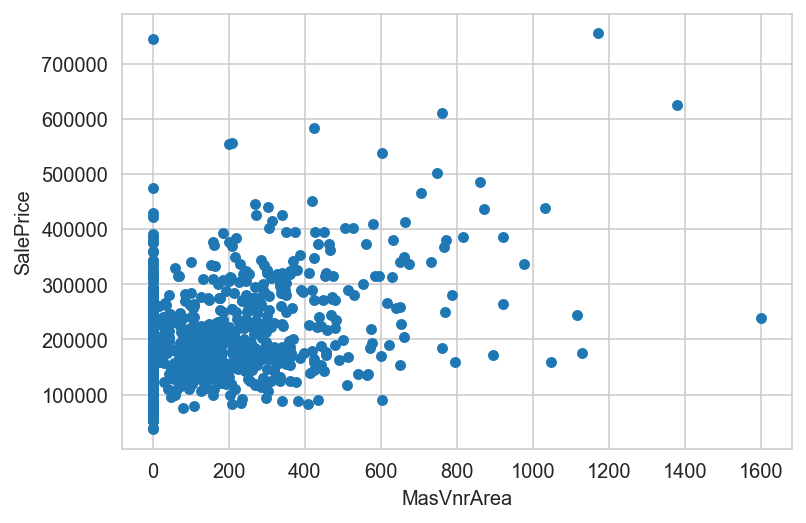

In [26]:
# peek on relationship of MasVnrArea and SalePrice
residential[['MasVnrType','MasVnrArea', 'SalePrice']].plot(kind ='scatter',
        x = 'MasVnrArea',
        y = 'SalePrice')
# with 0 sqft MasVnr does not impact on saleprice

In [27]:
# Type NaN replace with 'Unknown', Area replace with mean of MasVnrArea as more than half of this col are 0.0
residential.MasVnrArea.fillna(value = residential.MasVnrArea.mean(), inplace=True)
residential.MasVnrType.fillna(value = 'Unkown', inplace=True)

In [28]:
residential.MasVnrArea.value_counts()

0.0000      851
72.0000       8
108.0000      8
104.4043      8
180.0000      8
           ... 
426.0000      1
653.0000      1
796.0000      1
388.0000      1
415.0000      1
Name: MasVnrArea, Length: 328, dtype: int64

### fix BSMT columns
    ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']
    - BsmtQual: 37 NaN
    - BsmtCond: 37 NaN
    - BsmtExposure: 38 NaN
    - BsmtFinType1: 37 NaN
    - BsmtFinSF1: 0 NaN
    - BsmtFinType2: 38 NaN
    - BsmtFinSF2: 0 NaN
    - BsmtUnfSF: 0 NaN

In [29]:
residential.loc[residential.TotalBsmtSF == 0, ['BsmtExposure','BsmtFinType1','BsmtFinType2', 'BsmtQual', 'BsmtCond','TotalBsmtSF']]
# all 37 nan BsmtFinType1 do not have record of BsmtExposure, BsmtFinType2, BsmtQual, BsmtCond
# NaN bsmt TotalBsmtSF is 0

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtCond,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0
39,NaN,NaN,NaN,NaN,NaN,0
90,NaN,NaN,NaN,NaN,NaN,0
102,NaN,NaN,NaN,NaN,NaN,0
156,NaN,NaN,NaN,NaN,NaN,0
182,NaN,NaN,NaN,NaN,NaN,0
259,NaN,NaN,NaN,NaN,NaN,0
342,NaN,NaN,NaN,NaN,NaN,0
362,NaN,NaN,NaN,NaN,NaN,0
371,NaN,NaN,NaN,NaN,NaN,0


In [30]:
residential.loc[residential.TotalBsmtSF == 0, ['BsmtExposure','BsmtFinType1','BsmtFinType2', 'BsmtQual', 'BsmtCond','TotalBsmtSF']].isna().sum()

BsmtExposure    37
BsmtFinType1    37
BsmtFinType2    37
BsmtQual        37
BsmtCond        37
TotalBsmtSF      0
dtype: int64

In [31]:
# A: TotalBsmtSF = 0 ==> replace with "No Basement"(NA)
residential.loc[residential.TotalBsmtSF == 0, ['BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtCond','BsmtQual']] = 'NA'

In [32]:
# 38 Nan observed in BsmtExposure and BsmtFinType2, now 37 replaced with NA, inspect the ones left
residential[(residential.BsmtExposure.isna()) | (residential.BsmtFinType2.isna())][['BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtQual', 'BsmtCond','TotalBsmtSF']]

,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtQual,BsmtCond,TotalBsmtSF
332,No,GLQ,1124,NaN,479,Gd,TA,3206
948,NaN,Unf,0,Unf,0,Gd,TA,936


In [33]:
residential.BsmtExposure.value_counts()

No    947
Av    219
Gd    134
Mn    112
NA     37
Name: BsmtExposure, dtype: int64

In [34]:
# BsmtFinType2 NaN replace with same value as Type1
residential.loc[residential.BsmtFinType2.isna(),['BsmtFinType2']] = 'GLQ'
# BsmtExposure NaN replace with most frequent value, No
residential.loc[(residential.TotalBsmtSF != 0)& (residential.BsmtExposure.isna()),['BsmtExposure']] = 'No'

In [35]:
# BsmtUnfSF: Unfinished square feet of basement area
residential[['TotalBsmtSF','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2']]

,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2
0,856,150,706,0
1,1262,284,978,0
2,920,434,486,0
3,756,540,216,0
4,1145,490,655,0
...,...,...,...,...
1455,953,953,0,0
1456,1542,589,790,163
1457,1152,877,275,0
1458,1078,0,49,1029


In [36]:
# check if numbers match up
residential[['TotalBsmtSF','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2']][residential.TotalBsmtSF != (residential.BsmtFinSF1 + residential.BsmtFinSF2 + residential.BsmtUnfSF)]

,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2


In [37]:
residential.TotalBsmtSF.value_counts()
residential[['TotalBsmtSF','BsmtUnfSF','BsmtFinSF1','BsmtFinSF2']][residential.TotalBsmtSF==0]

,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2
17,0,0,0,0
39,0,0,0,0
90,0,0,0,0
102,0,0,0,0
156,0,0,0,0
182,0,0,0,0
259,0,0,0,0
342,0,0,0,0
362,0,0,0,0
371,0,0,0,0


### 2ndFlrSF: Second floor square feet (0 Nan)

In [38]:
residential['2ndFlrSF'].value_counts()
# 0 sqft means no 2nd floor?

0       824
728      10
504       9
672       8
546       8
       ... 
768       1
767       1
766       1
761       1
1872      1
Name: 2ndFlrSF, Length: 413, dtype: int64

### inspect FireplaceQu , 681 Nan

In [39]:
residential[['Fireplaces', 'FireplaceQu']].loc[residential.Fireplaces == 0].FireplaceQu.isna().sum()
# obeservation: 0 Fireplaces == no quality == NA

681

In [40]:
# replace NaN to NA
residential.FireplaceQu.fillna(value = 'NA', inplace=True)

### inspect Garage related cols
    ['GarageType', 'GarageYrBlt','GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
    GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond all have 79 NaN

In [41]:
residential[residential.GarageArea == 0][['GarageType', 'GarageYrBlt','GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']]
# garage area = 0 ==> all the rest should be "NA" (No Garage)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
99,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...
1349,NaN,NaN,NaN,0,0,NaN,NaN
1407,NaN,NaN,NaN,0,0,NaN,NaN
1449,NaN,NaN,NaN,0,0,NaN,NaN
1450,NaN,NaN,NaN,0,0,NaN,NaN


In [42]:
# GarageYrBlt col replace NaN to 0
# change dtype from float64 to int64
residential.GarageYrBlt.fillna(value = 0, inplace = True)
residential.GarageYrBlt = residential.GarageYrBlt.astype('int64')
residential['GarageYrBlt'].value_counts(dropna=False)

0       79
2005    65
2006    59
2004    53
2003    50
        ..
1934     2
1927     1
1933     1
1906     1
1908     1
Name: GarageYrBlt, Length: 97, dtype: int64

In [43]:
residential.loc[residential.GarageArea == 0,['GarageType', 'GarageFinish',  'GarageQual', 'GarageCond']] = 'NA'

In [44]:
residential[['GarageType', 'GarageYrBlt','GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']].loc[residential.GarageArea == 0]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NA,0,NA,0,0,NA,NA
48,NA,0,NA,0,0,NA,NA
78,NA,0,NA,0,0,NA,NA
89,NA,0,NA,0,0,NA,NA
99,NA,0,NA,0,0,NA,NA
...,...,...,...,...,...,...,...
1349,NA,0,NA,0,0,NA,NA
1407,NA,0,NA,0,0,NA,NA
1449,NA,0,NA,0,0,NA,NA
1450,NA,0,NA,0,0,NA,NA


In [45]:
residential[residential.GarageQual != residential.GarageCond][['GarageType', 'GarageYrBlt','GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
8,Detchd,1931,Unf,2,468,Fa,TA
9,Attchd,1939,RFn,1,205,Gd,TA
29,Detchd,1920,Unf,1,240,Fa,TA
42,Attchd,1983,RFn,2,504,TA,Gd
98,Basment,1920,Unf,1,366,Fa,TA
146,Detchd,1931,Unf,1,180,Fa,TA
149,Detchd,1936,Unf,1,240,Fa,TA
172,Attchd,1987,RFn,2,504,Gd,TA
179,Detchd,1935,Unf,2,480,Fa,TA
181,Detchd,1920,Unf,1,216,Fa,TA


### inspect Electrical
       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [46]:
residential.Electrical.value_counts(dropna=False)

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [47]:
# replace NaN with most frequent value
residential.Electrical.fillna(value = 'SBrkr', inplace=True)

### inspect Fence, 1179 nan
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

In [48]:
residential.Fence.value_counts(dropna=False)
# QUESTION: replace to 'No Fence'?

NaN      1172
MnPrv     155
GdPrv      59
GdWo       53
MnWw       11
Name: Fence, dtype: int64

In [49]:
# replace with Unknown
residential.Fence.fillna(value = 'Unknown', inplace = True)

### Final check columns

In [50]:
column_check(residential)

--------------ID--------------
dtype is int64
nan count is 0
1       0.00069
982     0.00069
980     0.00069
979     0.00069
978     0.00069
         ...   
486     0.00069
485     0.00069
484     0.00069
483     0.00069
1460    0.00069
Name: Id, Length: 1450, dtype: float64

--------------MSSUBCLASS--------------
dtype is int64
nan count is 0
20     0.368276
60     0.206207
50     0.096552
120    0.060000
30     0.046207
160    0.043448
70     0.040690
80     0.040000
90     0.035862
190    0.020000
85     0.013793
75     0.011034
45     0.008276
180    0.006897
40     0.002759
Name: MSSubClass, dtype: float64

--------------MSZONING--------------
dtype is object
nan count is 0
RL    0.793793
RM    0.150345
FV    0.044828
RH    0.011034
Name: MSZoning, dtype: float64

--------------LOTFRONTAGE--------------
dtype is float64
nan count is 0
74.680043     0.157931
60.000000     0.095862
70.000000     0.048276
80.000000     0.047586
50.000000     0.037931
                ...   
39.000000 

[]

### slice out fixed features and non-renovateable features

In [51]:
residential.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1450 non-null   int64  
 1   MSSubClass     1450 non-null   int64  
 2   MSZoning       1450 non-null   object 
 3   LotFrontage    1450 non-null   float64
 4   LotArea        1450 non-null   int64  
 5   LotShape       1450 non-null   object 
 6   LandContour    1450 non-null   object 
 7   LotConfig      1450 non-null   object 
 8   LandSlope      1450 non-null   object 
 9   Neighborhood   1450 non-null   object 
 10  Condition1     1450 non-null   object 
 11  BldgType       1450 non-null   object 
 12  HouseStyle     1450 non-null   object 
 13  OverallQual    1450 non-null   int64  
 14  OverallCond    1450 non-null   int64  
 15  YearBuilt      1450 non-null   int64  
 16  YearRemodAdd   1450 non-null   int64  
 17  RoofStyle      1450 non-null   object 
 18  Exterior

In [52]:
residential.to_csv('./processed data/residential.csv')

In [53]:
residential.shape

(1450, 69)

In [54]:
renovateables = ['OverallQual','OverallCond','MasVnrType','ExterQual','ExterCond','BsmtCond','BsmtFinType1','BsmtFinType2',
                    'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond',
                    'PavedDrive','Fence']

In [55]:
len(renovateables)

19

In [56]:
fixed = [col for col in residential.columns if col not in renovateables ]
fixed.remove('Id')
len(fixed)

49

#### fixed data
    - dummy categorical features

In [57]:
fixed_df = residential[fixed]
fixed_df

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,548,0,61,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,460,298,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,608,0,42,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,642,0,35,272,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,836,192,84,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Reg,Lvl,Inside,Gtl,Gilbert,Norm,...,460,0,40,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Reg,Lvl,Inside,Gtl,NWAmes,Norm,...,500,349,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Reg,Lvl,Inside,Gtl,Crawfor,Norm,...,252,0,60,0,0,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Reg,Lvl,Inside,Gtl,NAmes,Norm,...,240,366,0,112,0,4,2010,WD,Normal,142125


In [58]:
non_cat = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtUnfSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch']
fixed_df[non_cat]

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,65.0,8450,196.0,706,0,856,150,856,854,1710,548,0,61,0,0
1,80.0,9600,0.0,978,0,1262,284,1262,0,1262,460,298,0,0,0
2,68.0,11250,162.0,486,0,920,434,920,866,1786,608,0,42,0,0
3,60.0,9550,0.0,216,0,756,540,961,756,1717,642,0,35,272,0
4,84.0,14260,350.0,655,0,1145,490,1145,1053,2198,836,192,84,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,0.0,0,0,953,953,953,694,1647,460,0,40,0,0
1456,85.0,13175,119.0,790,163,1542,589,2073,0,2073,500,349,0,0,0
1457,66.0,9042,0.0,275,0,1152,877,1188,1152,2340,252,0,60,0,0
1458,68.0,9717,0.0,49,1029,1078,0,1078,0,1078,240,366,0,112,0


In [59]:
cat_cols = [col for col in fixed_df.columns if col not in non_cat]
cat_cols.remove('SalePrice')
fixed_df[cat_cols]

,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageCars,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,...,1,8,0,Attchd,2003,2,2,2008,WD,Normal
1,20,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,...,1,6,1,Attchd,1976,2,5,2007,WD,Normal
2,60,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,...,1,6,1,Attchd,2001,2,9,2008,WD,Normal
3,70,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,...,1,7,1,Detchd,1998,3,2,2006,WD,Abnorml
4,60,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,...,1,9,1,Attchd,2000,3,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Reg,Lvl,Inside,Gtl,Gilbert,Norm,1Fam,2Story,...,1,7,1,Attchd,1999,2,8,2007,WD,Normal
1456,20,RL,Reg,Lvl,Inside,Gtl,NWAmes,Norm,1Fam,1Story,...,1,7,2,Attchd,1978,2,2,2010,WD,Normal
1457,70,RL,Reg,Lvl,Inside,Gtl,Crawfor,Norm,1Fam,2Story,...,1,9,2,Attchd,1941,1,5,2010,WD,Normal
1458,20,RL,Reg,Lvl,Inside,Gtl,NAmes,Norm,1Fam,1Story,...,1,5,0,Attchd,1950,1,4,2010,WD,Normal


In [60]:
# Dummy categorical data
fixed_df_dummy = pd.get_dummies(data=fixed_df, columns=cat_cols, drop_first=True)

In [61]:
fixed_df_dummy.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,196.0,706,0,150,856,856,854,1710,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,1262,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,162.0,486,0,434,920,920,866,1786,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,0.0,216,0,540,756,961,756,1717,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,2198,...,0,0,0,0,1,0,0,0,1,0


In [62]:
# define train and test data
test_df = fixed_df_dummy[fixed_df_dummy['YrSold_2010'] == 1]
X_test = test_df.drop('SalePrice', axis = 1)
y_test = test_df.SalePrice

train_df = fixed_df_dummy[fixed_df_dummy['YrSold_2010'] == 0]
X_train = train_df.drop('SalePrice', axis = 1)
y_train = train_df.SalePrice

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1278, 473), (172, 473), (1278,), (172,))

### save data for question 1, fixed features_dummied

In [64]:
X_train.to_csv('./processed data/X_train_fixed.csv')
X_test.to_csv('./processed data/X_test_fixed.csv')
y_train.to_csv('./processed data/y_train.csv')
y_test.to_csv('./processed data/y_test.csv')

### save data for question 2, renovateable features_dummied

In [65]:
renovateables = ['OverallQual','OverallCond','MasVnrType','ExterQual','ExterCond','BsmtCond','BsmtFinType1','BsmtFinType2',
                    'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond',
                    'PavedDrive','Fence']
reno_df = residential[renovateables]
reno_df.shape

(1450, 19)

In [66]:
reno_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   OverallQual   1450 non-null   int64 
 1   OverallCond   1450 non-null   int64 
 2   MasVnrType    1450 non-null   object
 3   ExterQual     1450 non-null   object
 4   ExterCond     1450 non-null   object
 5   BsmtCond      1450 non-null   object
 6   BsmtFinType1  1450 non-null   object
 7   BsmtFinType2  1450 non-null   object
 8   HeatingQC     1450 non-null   object
 9   CentralAir    1450 non-null   object
 10  Electrical    1450 non-null   object
 11  KitchenQual   1450 non-null   object
 12  Functional    1450 non-null   object
 13  FireplaceQu   1450 non-null   object
 14  GarageFinish  1450 non-null   object
 15  GarageQual    1450 non-null   object
 16  GarageCond    1450 non-null   object
 17  PavedDrive    1450 non-null   object
 18  Fence         1450 non-null   object
dtypes: int

In [67]:
# convert OverallQual and OverallCond to object

reno_df.OverallQual = reno_df.OverallQual.astype('object')
reno_df.OverallCond = reno_df.OverallCond.astype('object')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
# these are all categorical dtype ==> dummy all
dummy_reno_df = pd.get_dummies(data = reno_df, drop_first=True)
dummy_reno_df.shape

(1450, 86)

In [69]:
X_test = dummy_reno_df.loc[residential[residential.YrSold == 2010].index, :]
X_train = dummy_reno_df.loc[residential[residential.YrSold < 2010].index, :]

In [70]:
X_train.shape, X_test.shape

((1278, 86), (172, 86))

#### save renovateable train test data

In [71]:
X_train.to_csv('./processed data/X_train_reno.csv')
X_test.to_csv('./processed data/X_test_reno.csv')